In [87]:
import pandas as pd

In [88]:
train_1 = pd.read_csv("../dataset/unprocessed/jigsaw-toxic-comment-classification-challenge/train.csv")
train_2 = pd.read_csv("../dataset/unprocessed/jigsaw-unintended-bias-in-toxicity-classification/train.csv")

In [89]:
test_1 = pd.read_csv("../dataset/unprocessed/jigsaw-toxic-comment-classification-challenge/test.csv")
test_2 = pd.read_csv("../dataset/unprocessed/jigsaw-unintended-bias-in-toxicity-classification/test.csv")

In [90]:
train_1.shape

(159571, 8)

In [91]:
test_1.shape

(153164, 2)

In [92]:
test_2.shape

(97320, 2)

### Add score feature and remove unnecessary columns from train_1

In [93]:
def label_toxicity_score(row):
    weights = {"toxic": 0.4, "severe_toxic": 0.2, "obscene": 0.4, "threat": 0.4, "insult": 0.2, "identity_hate": 0.3 }
    score = sum(row[key] * weight for key, weight in weights.items())

    if score > 1:
        score = 1
        
    return score

In [94]:
train_1["score"] = train_1.apply(label_toxicity_score, axis=1)

In [95]:
train_1 = train_1.loc[:, ["id", "comment_text", "score"]]
train_1.head()

,id,comment_text,score
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.0


### Add score feature and remove unnecessary columns from train_2

In [96]:
train_2["score"] = train_2["target"]

In [97]:
train_2 = train_2.loc[:, ["id", "comment_text", "score"]]
train_2.head()

,id,comment_text,score
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000
1,59849,Thank you!! This would make my life a lot less...,0.000000
2,59852,This is such an urgent design problem; kudos t...,0.000000
3,59855,Is this something I'll be able to install on m...,0.000000
4,59856,haha you guys are a bunch of losers.,0.893617


### Add train_2 to train_1, test_2 to test_1, and ignore duplicate data

In [98]:
def merge(ds1, ds2):
    # Create a set of all unique comment_texts in ds2
    ds2_comments_set = set(ds2["comment_text"].str.strip())

    # Create a boolean mask for rows in ds2 that should be added to ds1
    mask = ~ds2["comment_text"].str.strip().isin(ds1["comment_text"].str.strip())

    # Filter rows from ds2 that are not in ds1
    rows_to_add = ds2[mask]

    # Concatenate the rows_to_add to ds1
    ds1 = pd.concat([rows_to_add, ds1], ignore_index=True)

    return ds1

In [99]:
train = merge(train_1, train_2)
train.shape

(1964294, 3)

In [100]:
test = merge(test_1, test_2)
test.shape

(250441, 2)

In [101]:
train["score"].head(20)

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.893617
5     0.666667
6     0.457627
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.440000
12    0.000000
13    0.600000
14    0.500000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.500000
Name: score, dtype: float64

In [102]:
train["score"] = (train["score"].round(1) * 10).astype(int)

In [104]:
train["score"].head(20)

0     0
1     0
2     0
3     0
4     9
5     7
6     5
7     0
8     0
9     0
10    0
11    4
12    0
13    6
14    5
15    0
16    0
17    0
18    0
19    5
Name: score, dtype: int32

### Make sure comment_text is lowercase

In [105]:
train.loc[:, "comment_text"] = train["comment_text"].str.lower()
test.loc[:, "comment_text"] = test["comment_text"].str.lower()

### Drop any row that comment_text is empty

In [106]:
train = train.dropna(subset="comment_text", how='any',axis=0)

### Replacing contractions

In [107]:
import contractions

In [108]:
train.loc[:, "comment_text"] = train["comment_text"].apply(lambda x: contractions.fix(str(x)))
test.loc[:, "comment_text"] = test["comment_text"].apply(lambda x: contractions.fix(str(x)))

In [109]:
train.head()

,id,comment_text,score
0,59848,"this is so cool. it is like, 'would you want y...",0
1,59849,thank you!! this would make my life a lot less...,0
2,59852,this is such an urgent design problem; kudos t...,0
3,59855,is this something i will be able to install on...,0
4,59856,haha you guys are a bunch of losers.,9


### Removing URLs

In [110]:
import re

In [111]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [112]:
train.loc[:, "comment_text"] = train["comment_text"].apply(lambda x: remove_URL(x))
test.loc[:, "comment_text"] = test["comment_text"].apply(lambda x: remove_URL(x))

### Removing HTML Tags

In [113]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [114]:
train.loc[:, "comment_text"] = train["comment_text"].apply(lambda x: remove_html(x))
test.loc[:, "comment_text"] = test["comment_text"].apply(lambda x: remove_html(x))

### Remove non-ascii characters (since we are only concerned with English, and basic 

In [115]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

In [116]:
train.loc[:, "comment_text"] = train["comment_text"].apply(lambda x: remove_non_ascii(x))
test.loc[:, "comment_text"] = test["comment_text"].apply(lambda x: remove_non_ascii(x))

## We put test data through the cleaning process, because when we use the model, we will also clean the data first before putting it through the model.

In [117]:
import matplotlib.pyplot as plt
import numpy as np

(array([0.71715087, 0.01109306, 0.12706569, 0.03249315, 0.03182319,
        0.02342576, 0.01927362, 0.01393785, 0.0133916 , 0.01034521]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

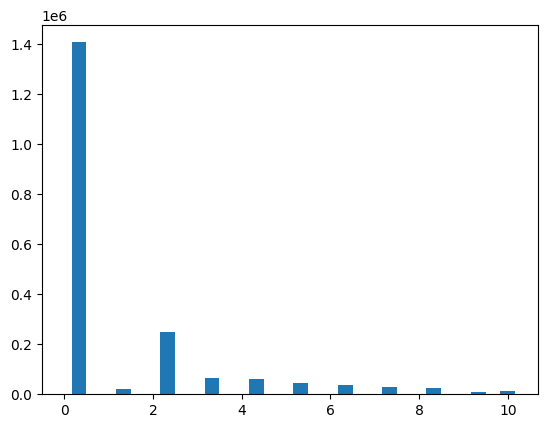

In [118]:
score = train["score"]
plt.hist(score, bins = 30, align = 'right')
weights = np.ones_like(score)/len(score)
plt.hist(score, weights=weights)

### fix data imbalance with SMOTE-ENN 

In [119]:
# !pip install imbalanced-learn scikit-learn pandas transformers
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# from imblearn.combine import SMOTEENN
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE

# import torch
# from transformers import RobertaTokenizer, RobertaModel

In [120]:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base')

In [121]:
x_train = train["comment_text"]
x_train.head()

0    this is so cool. it is like, 'would you want y...
1    thank you!! this would make my life a lot less...
2    this is such an urgent design problem; kudos t...
3    is this something i will be able to install on...
4                 haha you guys are a bunch of losers.
Name: comment_text, dtype: object

In [122]:
y_train = train["score"]
y_train.head()

0    0
1    0
2    0
3    0
4    9
Name: score, dtype: int32

In [123]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Function to tokenize a batch of data
# def tokenize_batch(batch, tokenizer):
#     return tokenizer(batch, padding=True, truncation=True, return_tensors='pt')

# # Define batch size
# batch_size = 32

# # Check if GPU is available and set the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# x_train_list = list(x_train)

# # Tokenize and encode data in batches
# encoded_batches = []
# dataloader = DataLoader(x_train_list, batch_size=batch_size, shuffle=False)

# for batch in dataloader:
#     encoded_batch = tokenize_batch(batch, tokenizer)
#     encoded_batches.append(encoded_batch)

In [124]:
# # Initialize an empty list to hold all CLS embeddings
# cls_embeddings_list = []

# # Process each batch through the model
# for encoded_batch in encoded_batches:
#     # Move inputs to the appropriate device
#     encoded_batch = {key: value.to(device) for key, value in encoded_batch.items()}
    
#     # Disable gradient calculation for efficiency
#     with torch.no_grad():
#         outputs = model(**encoded_batch)
    
#     # Extract CLS token embeddings and move them to CPU
#     cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu()
    
#     # Append to the list
#     cls_embeddings_list.append(cls_embeddings)

# # Concatenate all CLS embeddings to form the final array
# X = torch.cat(cls_embeddings_list, dim=0).numpy()


In [125]:
# over = SMOTE(sampling_strategy=0.5)
# under = RandomUnderSampler(sampling_strategy=0.3)

# # First, apply SMOTE to increase the minority class
# x_train_over, y_train_over = over.fit_resample(X, y_train)

# # Then, apply random undersampling to reduce the majority class
# x_train_combined, y_train_combined = under.fit_resample(x_train_over, y_train_over)

In [126]:
# x_train_combined("../dataset/processed/tmp_text.csv")
# y_train_combined("../dataset/processed/tmp_target.csv")
train.to_csv("../dataset/processed/train.csv")
test.to_csv("../dataset/processed/test.csv")